In [2]:
import re
import pprint
import fake_useragent
from fake_useragent import UserAgent
import arxiv
import pandas as pd
import urllib
import feedparser
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import numpy as np
import logging
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

Slow version of gensim.models.doc2vec is being used


In [2]:
#import the data, arxivDF_v2.csv was created in the last jupyter notebook
arxivDF=pd.read_csv('arxivDF_v2.csv', sep=',')

In [3]:
arxivDF.columns

Index(['Unnamed: 0', '_id', 'arxiv_affiliation', 'arxiv_comment', 'arxiv_doi',
       'arxiv_journal_ref', 'arxiv_primary_category', 'contributors',
       'guidislink', 'id', 'link', 'links', 'published', 'published_parsed',
       'summary', 'summary_detail', 'tags', 'title', 'title_detail', 'updated',
       'updated_parsed'],
      dtype='object')

In [4]:
X_train=arxivDF

In [5]:
df = X_train.fillna('1')

create (big list of paper abstracts):

In [6]:
summaries=list(df.summary)

In [7]:
documents=[]

for summary in summaries:
    if summary != np.nan:
        documents.append(summary)

Set your number of 'topics' to be created and tf-idf vectorize the documents:

In [9]:
no_features = 1000
no_topics = 20

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')

In [11]:
tfidf = tfidf_vectorizer.fit_transform(documents)

In [12]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

Now run NMF on the vectorized documents and print the topics and their 'top words'

In [13]:
#running NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [15]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print( "Topic %d:" % (topic_idx))
        print( " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [17]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, 15)

Topic 0:
model models parameters bayesian process inference modeling stochastic latent selection markov based simple dynamics population
Topic 1:
quantum classical theory mechanics semiclassical physics chaos states mechanical localization body measurement limit atoms atom
Topic 2:
algebra algebras group space prove spaces finite groups theory theorem category mathbb lie let compact
Topic 3:
network networks nodes neural social node structure complex topology synchronization degree community communication world link
Topic 4:
data analysis sets clustering real methods statistical using large set high datasets experimental available structure
Topic 5:
learning machine neural deep training classification tasks task methods algorithms models performance state art features
Topic 6:
flow turbulence velocity fluid turbulent flows scale shear reynolds numerical large simulations number surface scaling
Topic 7:
algorithm problem algorithms problems optimal optimization complexity number solutio

Split off the year from the published column of the dataframe:

In [18]:
published=list(df['published_parsed'])

In [19]:
year=[]

for item in published:
    year.append(item.split(',')[0])

In [20]:
df['year'] = df['published'].map(lambda x: x[0:4])

In [22]:
df.shape

(648010, 22)

In [21]:
df.columns

Index(['Unnamed: 0', '_id', 'arxiv_affiliation', 'arxiv_comment', 'arxiv_doi',
       'arxiv_journal_ref', 'arxiv_primary_category', 'contributors',
       'guidislink', 'id', 'link', 'links', 'published', 'published_parsed',
       'summary', 'summary_detail', 'tags', 'title', 'title_detail', 'updated',
       'updated_parsed', 'year'],
      dtype='object')

In [27]:
df2=df.iloc[:,[6,9,21,14]]

In [28]:
df2.head()

,arxiv_primary_category,id,year,summary
0,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/cs/0210001v1,2002,We discuss the scientific contributions of Eds...
1,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/1312.3213v1,2013,How to manage knowledge on the Web.
2,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/cs/0106022v1,2001,Computer scientists are in the position to cre...
3,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/cs/0306132v1,2003,In this work we firstly review some results in...
4,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/cs/0607022v1,2006,This is a rough draft synopsis of a book prese...


Now, we tfidf vectorize all the summaries (again), but cluster each abstract into a 'topic'. Because the column with the largest value will be the 'topic' that the abstract belongs to, we can group each paper into a specific 'topic'.

In [29]:
temp=nmf.transform(tfidf_vectorizer.transform(df2.summary))

In [30]:
tempDF=pd.DataFrame(temp, columns=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

In [31]:
df2['topic']=list(tempDF.idxmax(axis=1))

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [32]:
df2.head()

,arxiv_primary_category,id,year,summary,topic
0,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/cs/0210001v1,2002,We discuss the scientific contributions of Eds...,20
1,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/1312.3213v1,2013,How to manage knowledge on the Web.,16
2,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/cs/0106022v1,2001,Computer scientists are in the position to cre...,16
3,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/cs/0306132v1,2003,In this work we firstly review some results in...,20
4,"{'term': 'cs.GL', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/cs/0607022v1,2006,This is a rough draft synopsis of a book prese...,16


create a 'category' column in the dataframe to check how well our topic modeling did:

In [55]:
primary=list(df2.arxiv_primary_category)

In [56]:
secondary=[]
for x in primary:
    secondary.append(x.split(',')[0])

In [59]:
category=[]
for x in secondary:
    category.append(x.split(':')[1])

In [61]:
category=[x.strip(' ') for x in category]

In [64]:
category=[x.strip('\'') for x in category]

In [67]:
df2['category']=category

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [114]:
#df2.to_csv('nmf_with_topics.csv') #--- this csv file has 648,010 rows

In [3]:
df2=pd.read_csv('nmf_with_topics.csv')

In [16]:
df2.sort(columns=['topic']).tail(100)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Unnamed: 0,arxiv_primary_category,id,year,summary,topic,category
160041,160041,"{'term': 'cs.GT', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/1208.3976v1,2012,"When applied to the same game, probability the...",20,cs.GT
577672,577672,"{'term': 'quant-ph', 'scheme': 'http://arxiv.o...",http://arxiv.org/abs/quant-ph/0303103v2,2003,For chaotic systems there is a theory for the ...,20,quant-ph
159994,159994,"{'term': 'cs.IR', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/1205.1505v1,2012,In this work we explore the ability of the Goo...,20,cs.IR
159922,159922,"{'term': 'q-fin.ST', 'scheme': 'http://arxiv.o...",http://arxiv.org/abs/1011.3225v2,2010,We investigate financial market correlations u...,20,q-fin.ST
159919,159919,"{'term': 'stat.AP', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/1011.2924v1,2010,"From the perspective of the network theory, th...",20,stat.AP
577725,577725,"{'term': 'nlin.AO', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/0704.1650v3,2007,The incoherent state of the Kuramoto model of ...,20,nlin.AO
577655,577655,"{'term': 'quant-ph', 'scheme': 'http://arxiv.o...",http://arxiv.org/abs/quant-ph/0111125v4,2001,The idea of perturbation independent decay (PI...,20,quant-ph
160386,160386,"{'term': 'physics.soc-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1505.03875v2,2015,Evolutionary game theory is a common framework...,20,physics.soc-ph
577500,577500,"{'term': 'cond-mat', 'scheme': 'http://arxiv.o...",http://arxiv.org/abs/cond-mat/9902168v3,1999,We make the first steps towards a generic theo...,20,cond-mat
577499,577499,"{'term': 'cond-mat.mtrl-sci', 'scheme': 'http:...",http://arxiv.org/abs/cond-mat/9811079v2,1998,The Kolmogorov-Johnson-Mehl-Avrami (KJMA) theo...,20,cond-mat.mtrl-sci


In [17]:
df=df2

** A lot of physics papers were put into topic #9 **

In [32]:
df[df['topic'] == 9]

,Unnamed: 0,arxiv_primary_category,id,year,summary,topic,category
100,100,"{'term': 'math.ST', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/math/0410574v2,2004,"Citation distributions for 1992, 1994, 1996, 1...",9,math.ST
132,132,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1705.10275v1,2017,We demonstrated a novel on-chip polarization c...,9,physics.app-ph
135,135,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1704.06815v1,2017,The widely used ferroelectric ceramics based a...,9,physics.app-ph
136,136,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1704.07362v1,2017,Annealing treatment is an important step of ro...,9,physics.app-ph
142,142,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1705.01056v1,2017,"We propose a magnetic multilayer layout, in wh...",9,physics.app-ph
143,143,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1705.03569v1,2017,An extended social force model with a dynamic ...,9,physics.app-ph
148,148,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1705.06867v1,2017,The field enhancement factor at the emitter ti...,9,physics.app-ph
149,149,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1705.07608v1,2017,The development of technologically relevant sk...,9,physics.app-ph
150,150,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1705.07711v1,2017,The first hygroscopic tunable cloth actuator i...,9,physics.app-ph
153,153,"{'term': 'physics.app-ph', 'scheme': 'http://a...",http://arxiv.org/abs/1705.08115v1,2017,A compact bilateral single conductor surface w...,9,physics.app-ph


In [221]:
df2[df2['topic'] == '1'].groupby('year').topic.count()

year
1993      16
1994      33
1995      69
1996      71
1997     113
1998      64
1999     174
2000     168
2001     176
2002     283
2003     286
2004     299
2005     377
2006     561
2007     673
2008     958
2009     984
2010    1512
2011    1665
2012    2461
2013    2890
2014    3356
2015    3925
2016    5168
Name: topic, dtype: int64

Everything below could've (and should have) been done in a loop :)
   

The plots below show the 'topic' growth over time

In [223]:
topic2=pd.DataFrame({'count': df2[df2['topic'] =='2'].groupby('year').topic.count()}).reset_index()

In [224]:
topic3=pd.DataFrame({'count': df2[df2['topic'] =='3'].groupby('year').topic.count()}).reset_index()

In [225]:
topic4=pd.DataFrame({'count': df2[df2['topic'] =='4'].groupby('year').topic.count()}).reset_index()

In [226]:
topic5=pd.DataFrame({'count': df2[df2['topic'] =='5'].groupby('year').topic.count()}).reset_index()

In [227]:
topic6=pd.DataFrame({'count': df2[df2['topic'] =='6'].groupby('year').topic.count()}).reset_index()

In [228]:
topic7=pd.DataFrame({'count': df2[df2['topic'] =='7'].groupby('year').topic.count()}).reset_index()

In [229]:
topic8=pd.DataFrame({'count': df2[df2['topic'] =='8'].groupby('year').topic.count()}).reset_index()

In [230]:
topic9=pd.DataFrame({'count': df2[df2['topic'] =='9'].groupby('year').topic.count()}).reset_index()

In [231]:
topic10=pd.DataFrame({'count': df2[df2['topic'] =='10'].groupby('year').topic.count()}).reset_index()

In [232]:
topic11=pd.DataFrame({'count': df2[df2['topic'] =='11'].groupby('year').topic.count()}).reset_index()

In [233]:
topic12=pd.DataFrame({'count': df2[df2['topic'] =='12'].groupby('year').topic.count()}).reset_index()

In [234]:
topic13=pd.DataFrame({'count': df2[df2['topic'] =='13'].groupby('year').topic.count()}).reset_index()

In [235]:
topic14=pd.DataFrame({'count': df2[df2['topic'] =='14'].groupby('year').topic.count()}).reset_index()

In [236]:
topic15=pd.DataFrame({'count': df2[df2['topic'] =='15'].groupby('year').topic.count()}).reset_index()

In [237]:
topic16=pd.DataFrame({'count': df2[df2['topic'] =='16'].groupby('year').topic.count()}).reset_index()

In [238]:
topic17=pd.DataFrame({'count': df2[df2['topic'] =='17'].groupby('year').topic.count()}).reset_index()

In [239]:
topic18=pd.DataFrame({'count': df2[df2['topic'] =='18'].groupby('year').topic.count()}).reset_index()

In [240]:
topic19=pd.DataFrame({'count': df2[df2['topic'] =='19'].groupby('year').topic.count()}).reset_index()

In [241]:
topic20=pd.DataFrame({'count': df2[df2['topic'] =='20'].groupby('year').topic.count()}).reset_index()

** should've wrote a function -_- **

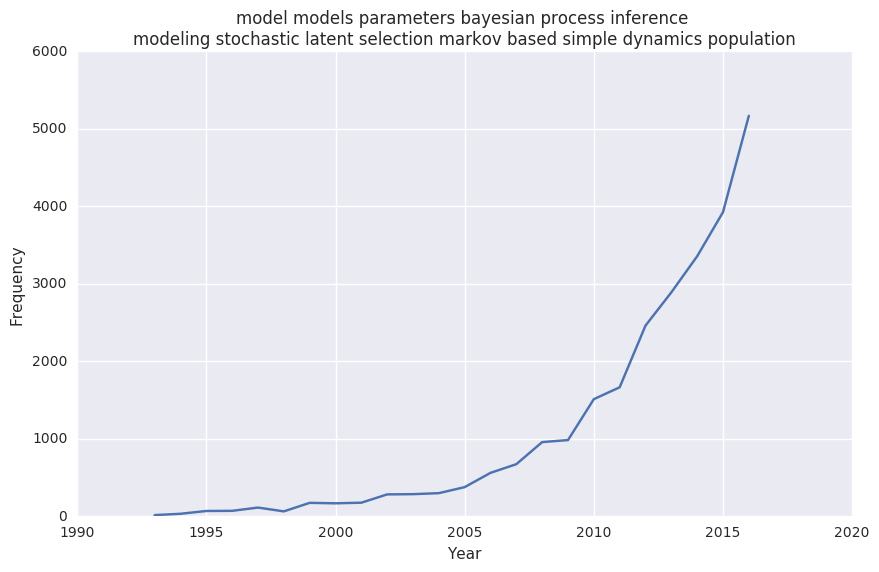

In [268]:
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic1['year'], topic1['count']);
plt.title('model models parameters bayesian process inference \
\nmodeling stochastic latent selection markov based simple dynamics population')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

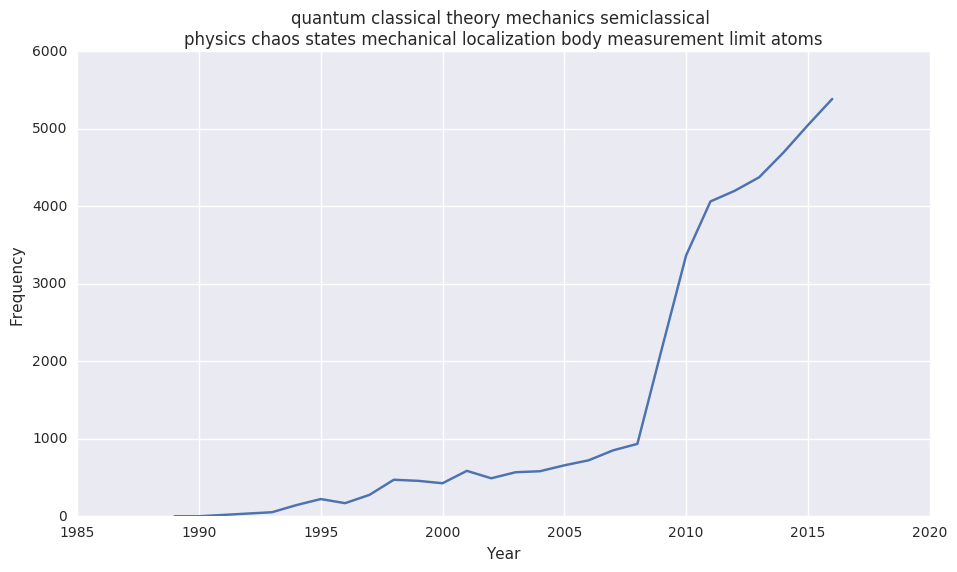

In [270]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic2['year'], topic2['count']);
plt.title('quantum classical theory mechanics semiclassical \nphysics chaos states mechanical \
localization body measurement limit atoms')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show();

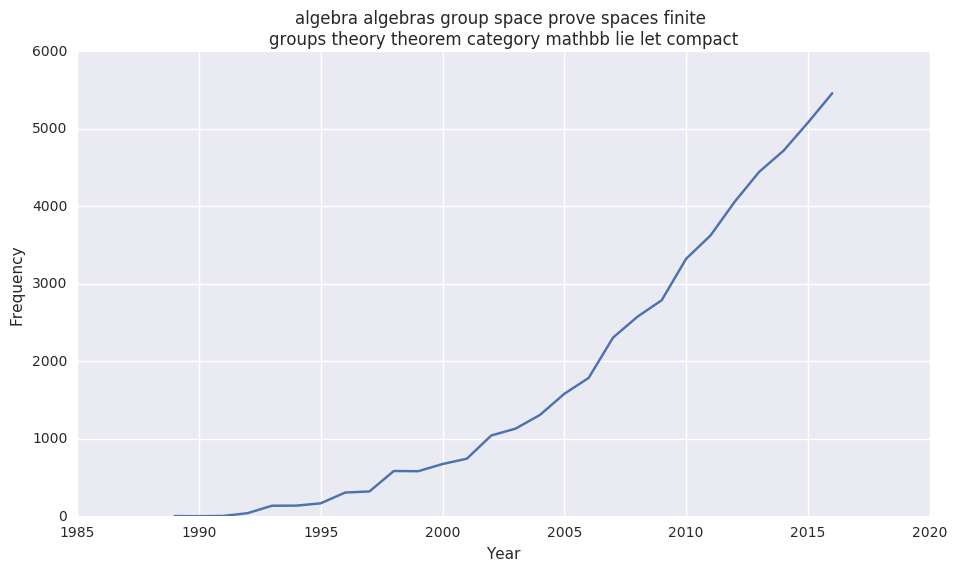

In [275]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic3['year'], topic3['count']);
plt.title('algebra algebras group space prove spaces finite \
\ngroups theory theorem category mathbb lie let compact');
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

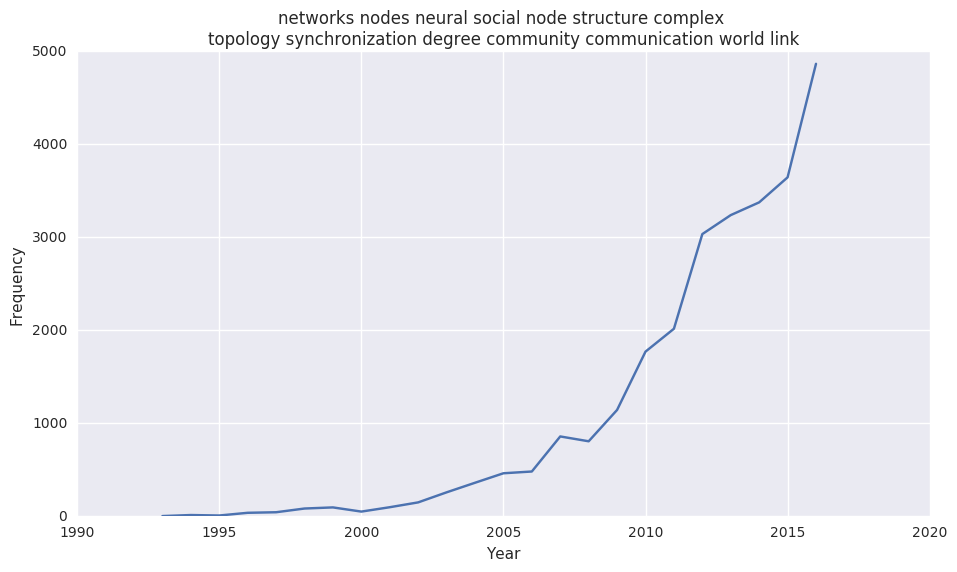

In [277]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic4['year'], topic4['count']);
plt.title('networks nodes neural social node structure complex \
\ntopology synchronization degree community communication world link')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

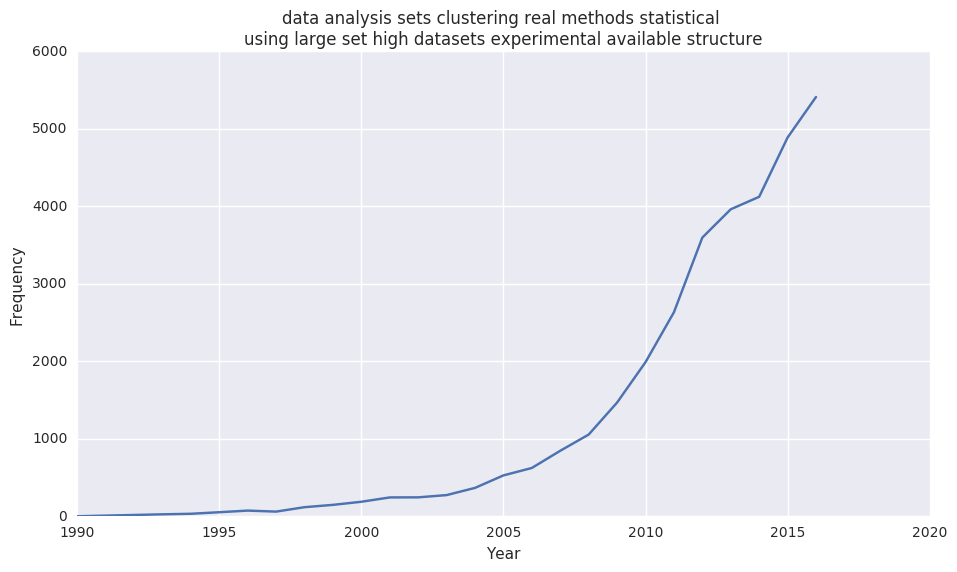

In [278]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic5['year'], topic5['count']);
plt.title('data analysis sets clustering real methods statistical \
\nusing large set high datasets experimental available structure')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

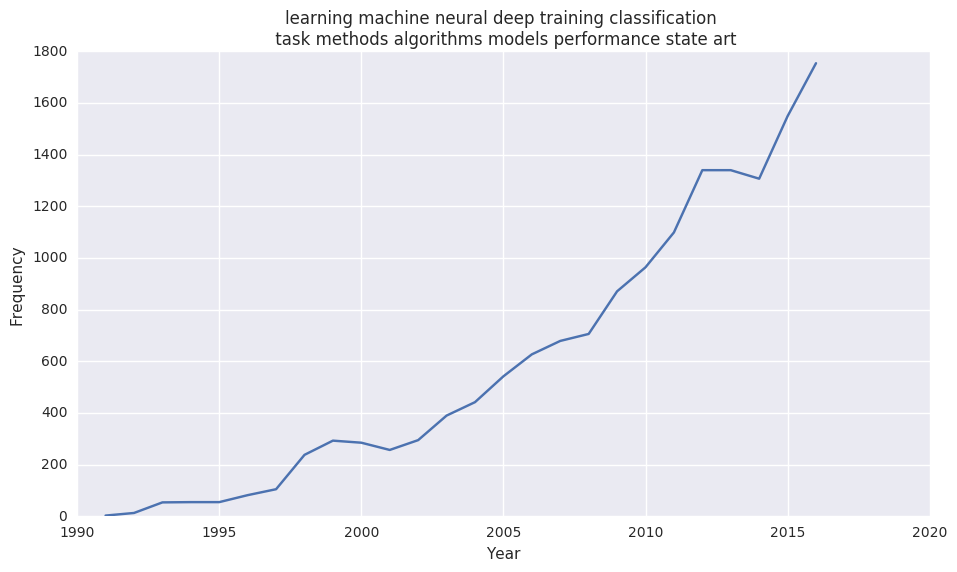

In [280]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic6['year'], topic6['count']);
plt.title('learning machine neural deep training classification \
\n task methods algorithms models performance state art')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

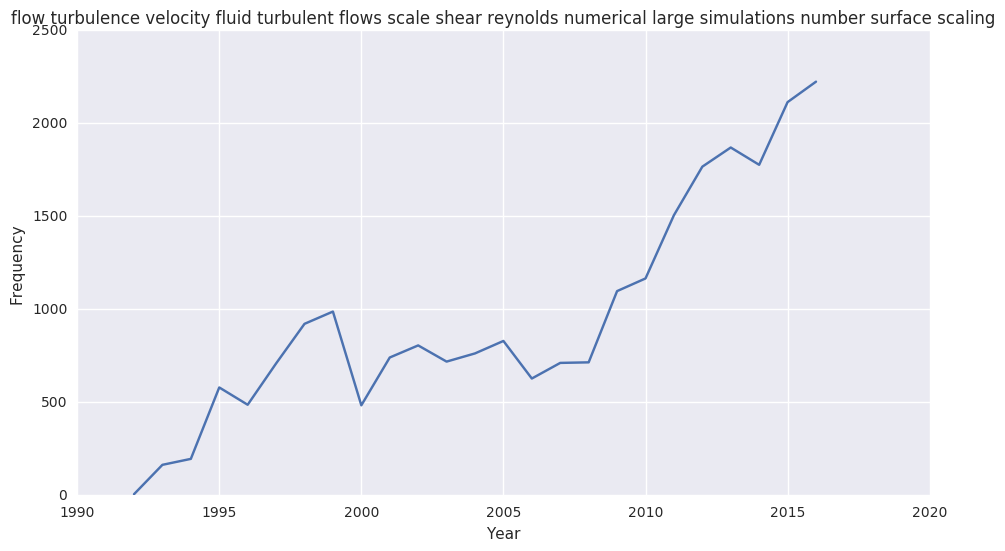

In [293]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic7['year'], topic7['count']);
plt.title('flow turbulence velocity fluid turbulent flows scale shear \
reynolds numerical large simulations number surface scaling')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

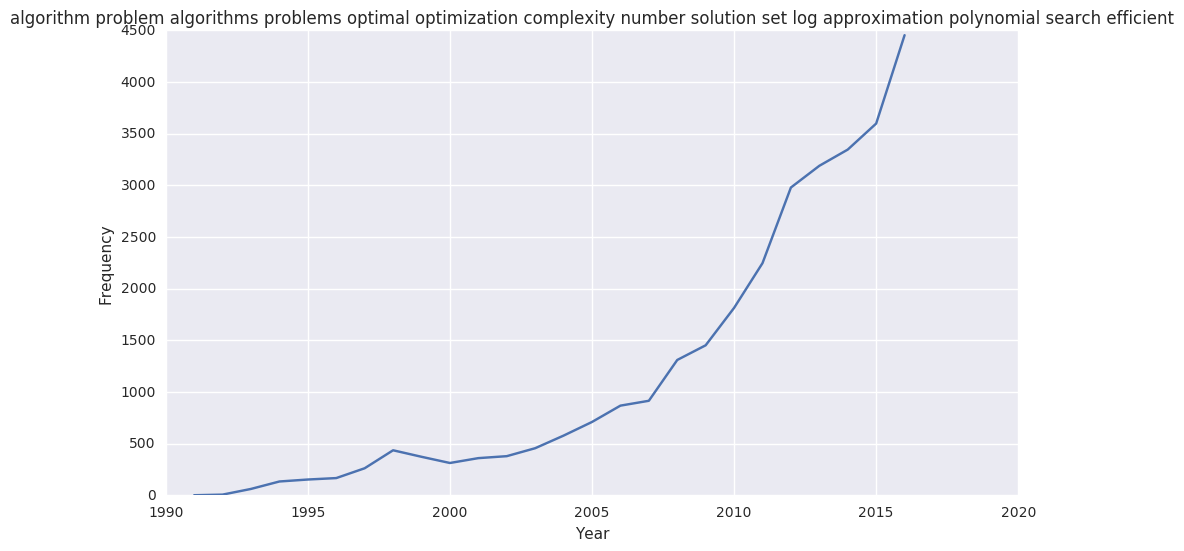

In [294]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic8['year'], topic8['count']);
plt.title('algorithm problem algorithms problems optimal optimization complexity number \
solution set log approximation polynomial search efficient')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

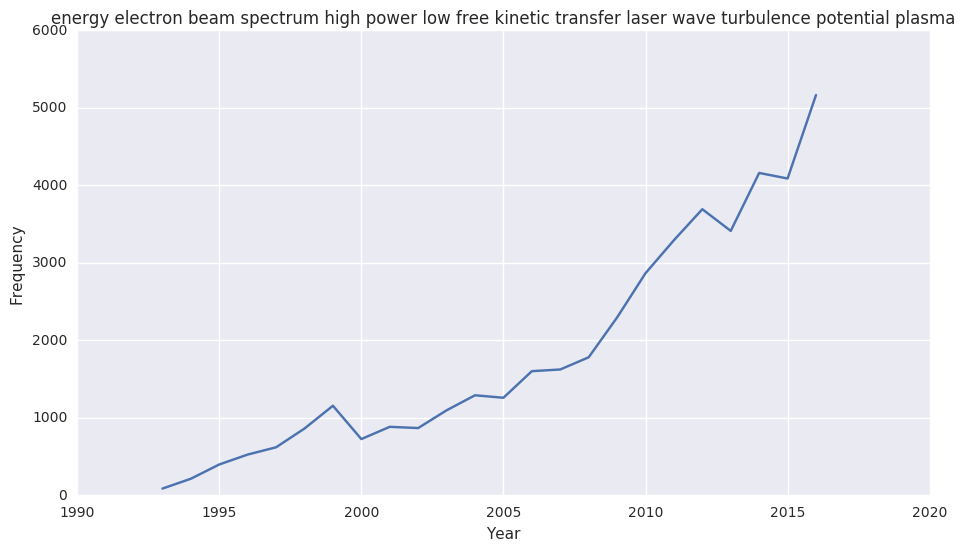

In [295]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic9['year'], topic9['count']);
plt.title('energy electron beam spectrum high power low free \
kinetic transfer laser wave turbulence potential plasma')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

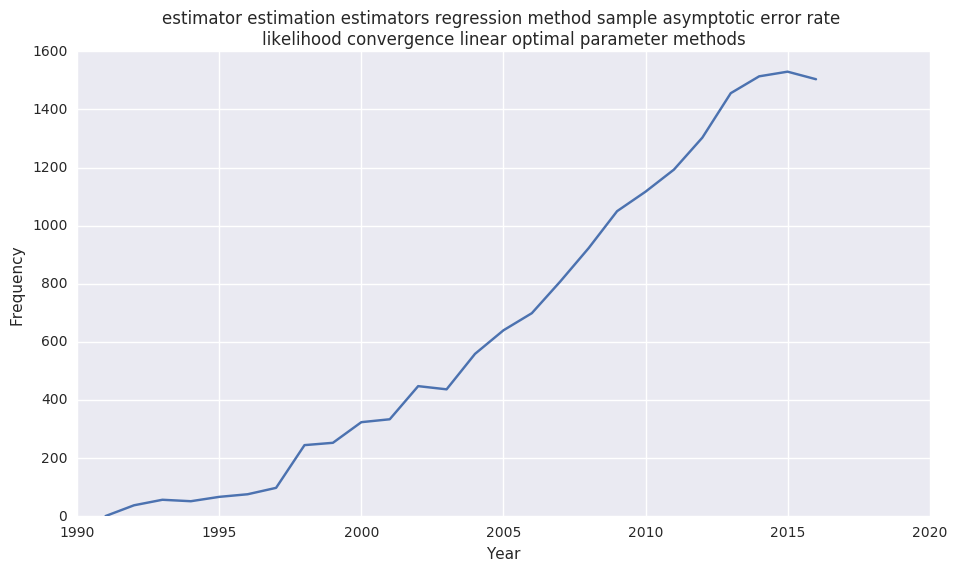

In [297]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic10['year'], topic10['count']);
plt.title('estimator estimation estimators regression method sample asymptotic error rate \
\nlikelihood convergence linear optimal parameter methods')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

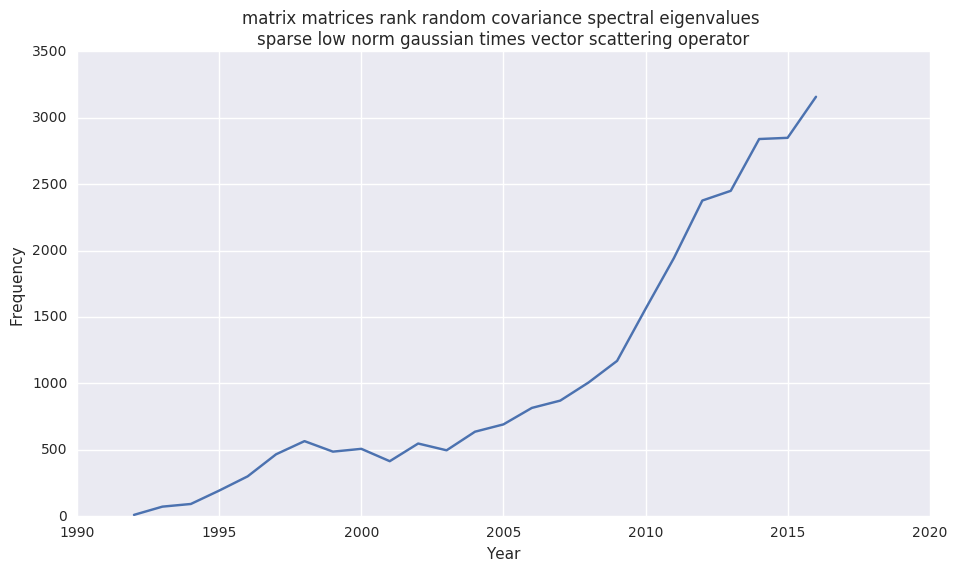

In [299]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic11['year'], topic11['count']);
plt.title('matrix matrices rank random covariance spectral eigenvalues \
\nsparse low norm gaussian times vector scattering operator')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

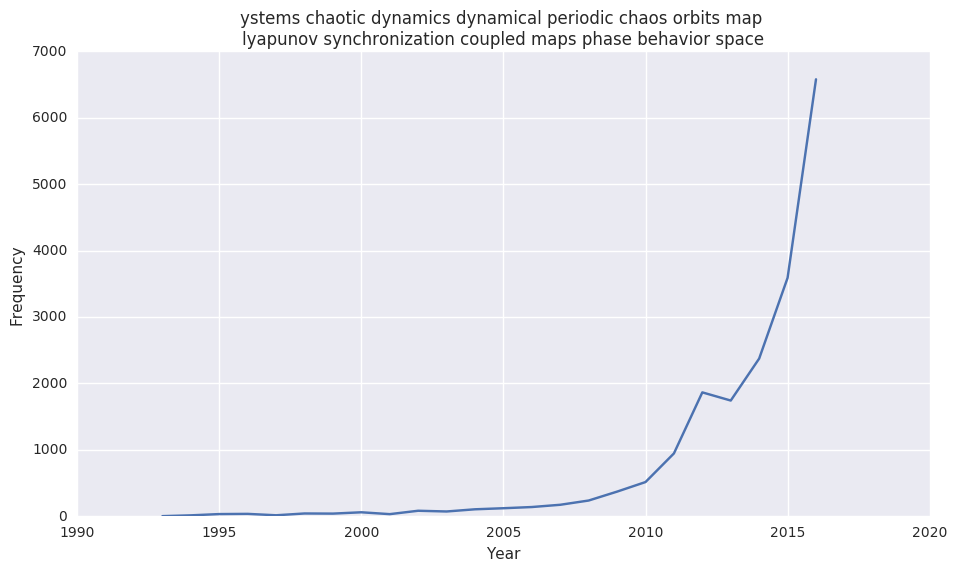

In [300]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic12['year'], topic12['count']);
plt.title('ystems chaotic dynamics dynamical periodic chaos orbits map \
\nlyapunov synchronization coupled maps phase behavior space')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

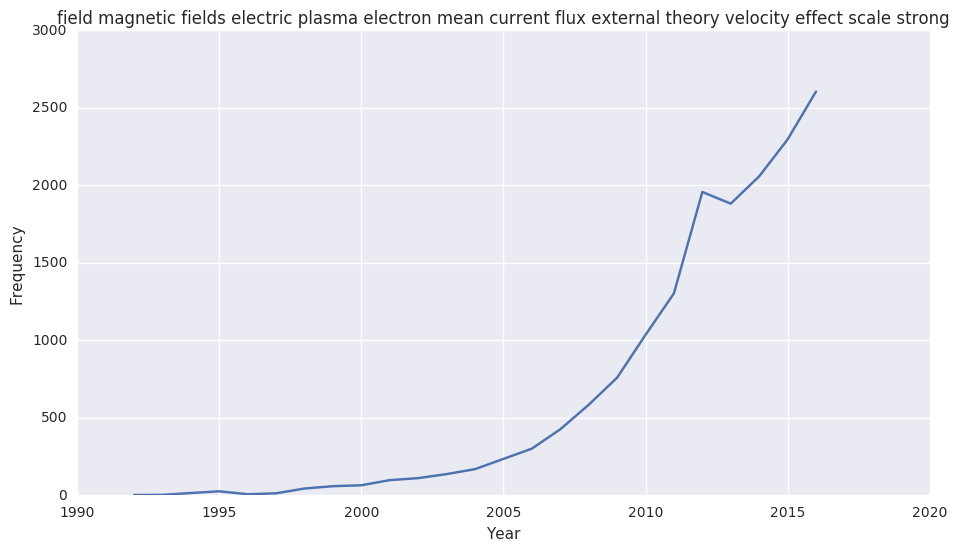

In [301]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic13['year'], topic13['count']);
plt.title('field magnetic fields electric plasma electron mean \
current flux external theory velocity effect scale strong')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

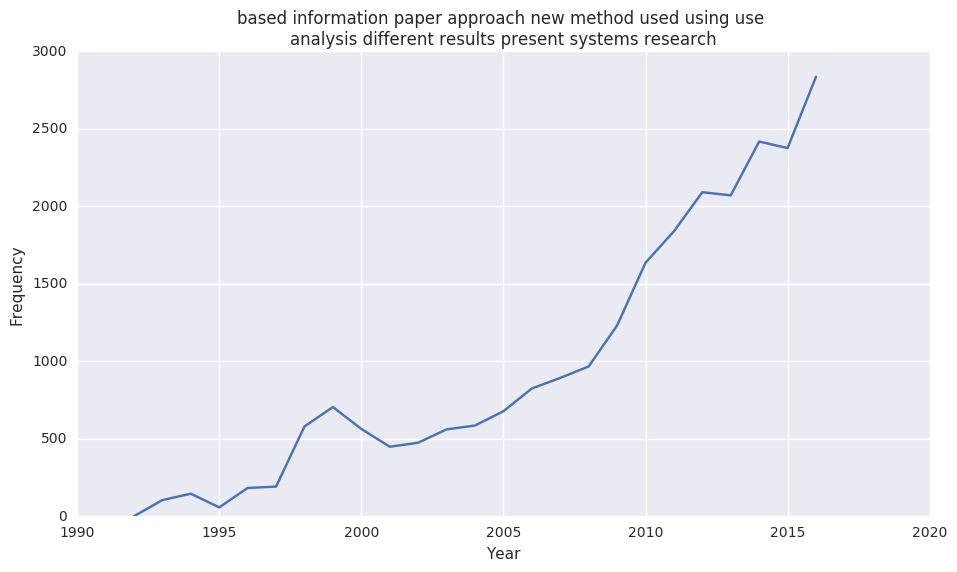

In [302]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic14['year'], topic14['count']);
plt.title('based information paper approach new method used using use \
\nanalysis different results present systems research')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

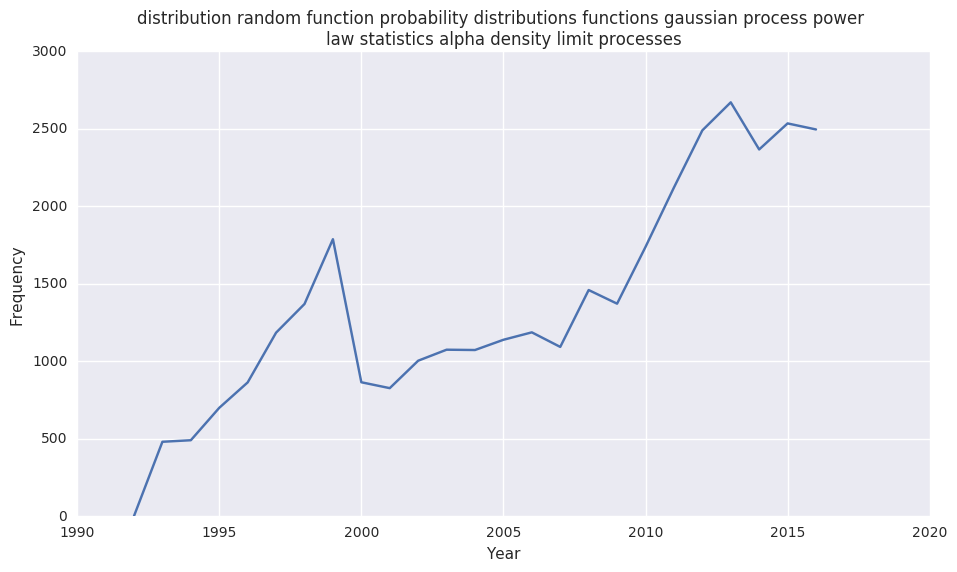

In [303]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic15['year'], topic15['count']);
plt.title('distribution random function probability distributions functions gaussian process power \
\nlaw statistics alpha density limit processes')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

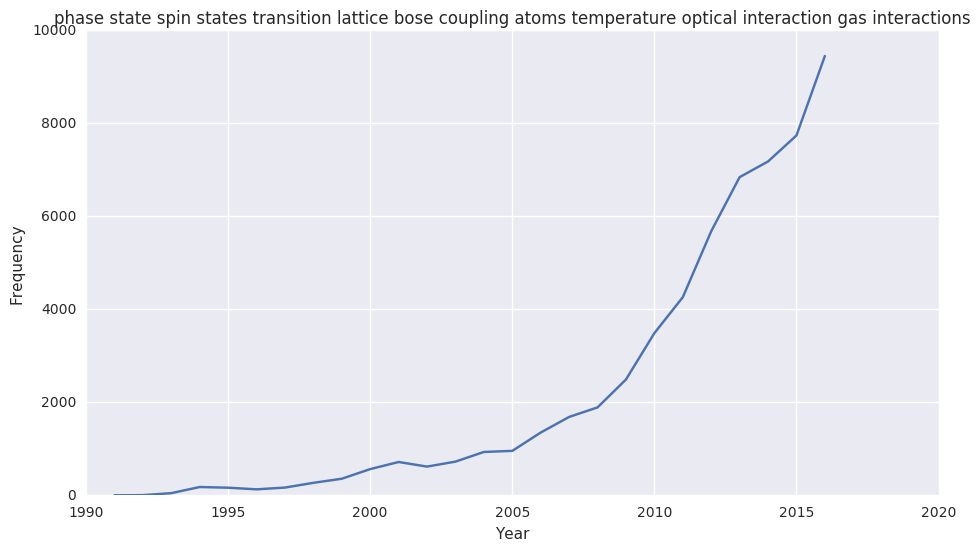

In [310]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic16['year'], topic16['count']);
plt.title('phase state spin states transition lattice bose coupling \
atoms temperature optical interaction gas interactions')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

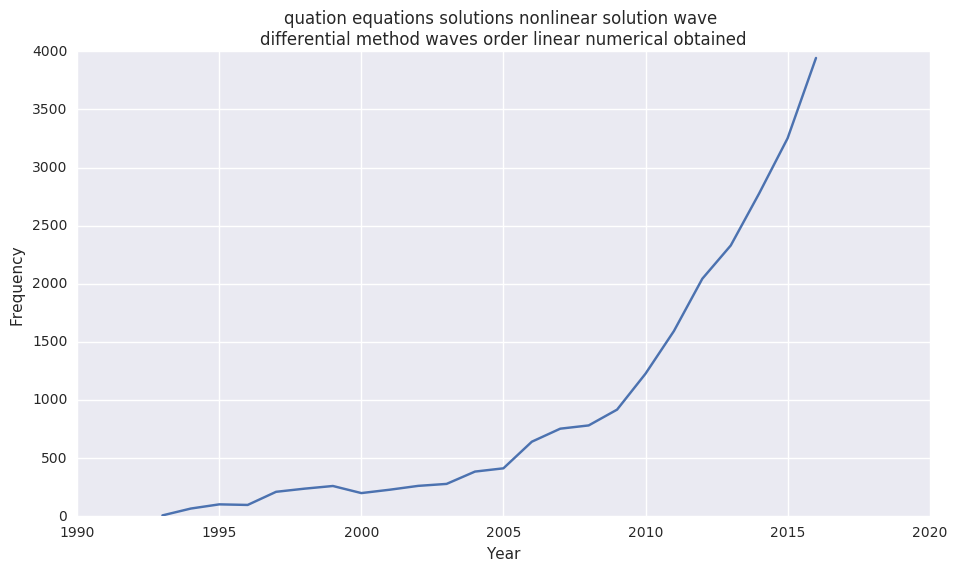

In [312]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic17['year'], topic17['count']);
plt.title('quation equations solutions nonlinear solution wave \
\ndifferential method waves order linear numerical obtained')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

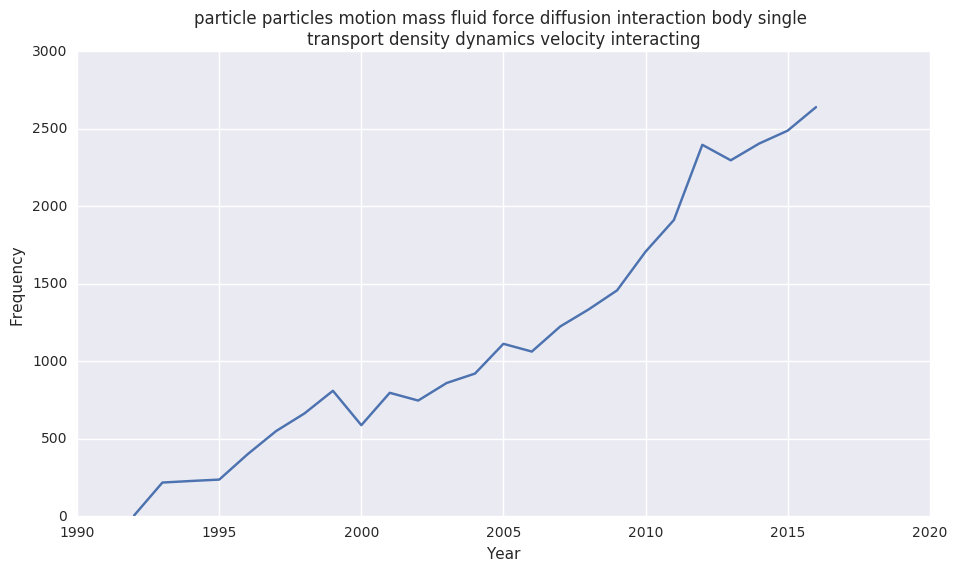

In [314]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic18['year'], topic18['count']);
plt.title('particle particles motion mass fluid force diffusion interaction body single \
\ntransport density dynamics velocity interacting')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

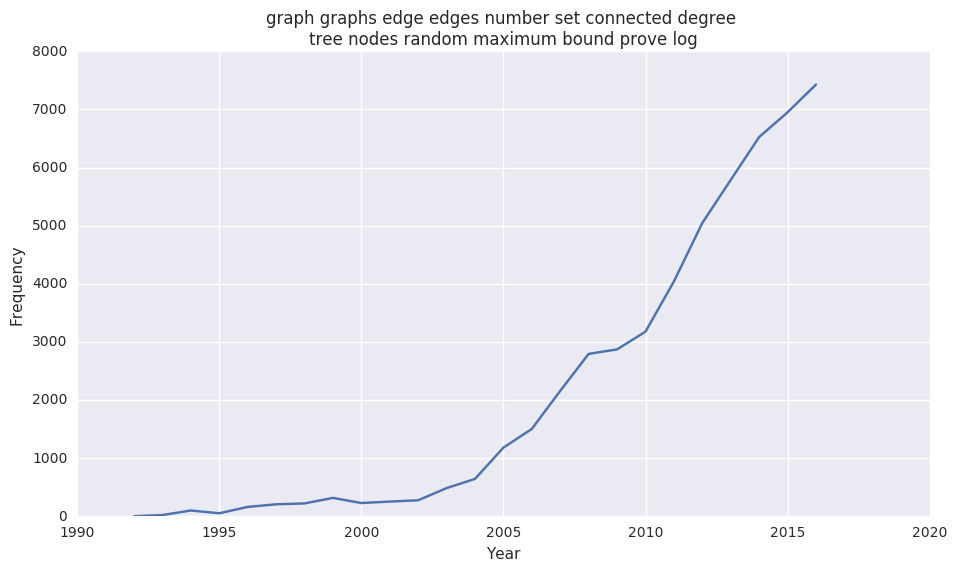

In [315]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic19['year'], topic19['count']);
plt.title('graph graphs edge edges number set connected degree \
\ntree nodes random maximum bound prove log')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

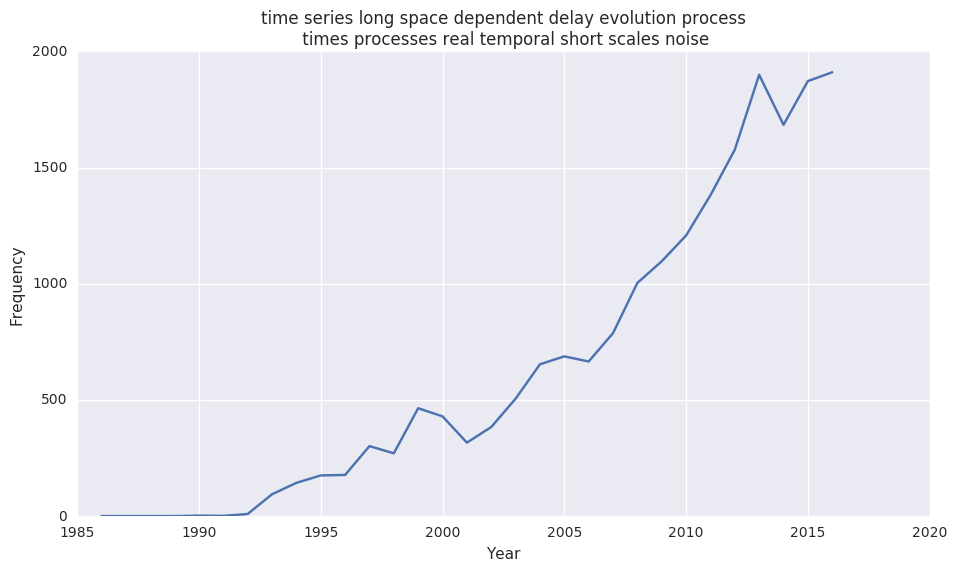

In [316]:
plt.figure(num=None, figsize=(11, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(topic20['year'], topic20['count']);
plt.title('time series long space dependent delay evolution process\
\n times processes real temporal short scales noise')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()